In [2]:
# Required Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Load CSV file
data = pd.read_csv('train.csv')

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Select relevant columns
data = data[['building_id', 'meter', 'timestamp', 'meter_reading']]

# Normalize meter_reading
scaler = MinMaxScaler()
data['meter_reading'] = scaler.fit_transform(data[['meter_reading']])

# Group by building_id and meter to create time series
grouped = data.groupby(['building_id', 'meter'])

# Create sequences of time series data
def create_sequences(group, sequence_length=24):
    sequences = []
    for i in range(len(group) - sequence_length):
        seq = group['meter_reading'].iloc[i:i+sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

# Generate sequences
sequences_list = []
for _, group in grouped:
    seq = create_sequences(group)
    if len(seq) > 0:
        sequences_list.append(seq)

# Check if sequences_list is empty or has inconsistent shapes
if len(sequences_list) > 0:
    # Ensure sequences have consistent shapes
    sequence_lengths = [seq.shape[1] for seq in sequences_list if len(seq) > 0]

    # Stack sequences only if they are consistent
    if len(set(sequence_lengths)) == 1:
        sequences = np.vstack(sequences_list)
    else:
        sequences = np.concatenate(sequences_list, axis=0)

# Check if sequences are successfully generated
if len(sequences) == 0:
    raise ValueError("No valid sequences generated. Check input data and sequence length.")

print(f"Generated {len(sequences)} sequences of shape {sequences.shape}")

Generated 20158980 sequences of shape (20158980, 24)


In [4]:
import tensorflow as tf
import numpy as np

# Define necessary parameters
batch_size = 64
seq_len = 24
latent_dim = 100
epochs = 100
learning_rate = 0.0002

# Enable eager execution to prevent conversion issues
tf.config.run_functions_eagerly(True)

# Define Generator Model
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, latent_dim)),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh'))
    ])
    return model

# Define Discriminator Model
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define Loss Functions
def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return tf.reduce_mean(real_loss + fake_loss)

# Build and Compile Models
generator = build_generator()
discriminator = build_discriminator()

# Build models to ensure the optimizers recognize them
_ = generator(tf.random.normal([1, seq_len, latent_dim]))
_ = discriminator(tf.random.normal([1, seq_len, 1]))

# Define Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Training Step
def train_step(real_data):
    # Sample random noise
    noise = tf.random.normal([batch_size, seq_len, latent_dim])

    # Generate synthetic sequences
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        # Discriminator predictions
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        # Calculate Losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply Gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate Dummy Sequence Data for Training
sequences = np.random.rand(1000, seq_len, 1).astype(np.float32)

# Training Loop
for epoch in range(epochs):
    # Sample a batch of real sequences
    idx = np.random.randint(0, len(sequences), batch_size)
    real_sequences = sequences[idx]

    # Convert to Tensor
    real_sequences = tf.convert_to_tensor(real_sequences)

    # Train the model
    gen_loss, disc_loss = train_step(real_sequences)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | Generator Loss: {gen_loss.numpy():.4f} | Discriminator Loss: {disc_loss.numpy():.4f}")

# -------------------------------
# ✅ Generate Sequences for Evaluation after Training
# -------------------------------
num_samples_to_generate = 1000
noise = tf.random.normal([num_samples_to_generate, seq_len, latent_dim])
generated_sequences = generator(noise, training=False).numpy()

# -------------------------------
# ✅ Compute statistics for real and generated data
# -------------------------------
def compute_statistics(sequences):
    mean = np.mean(sequences, axis=(0, 1))
    std = np.std(sequences, axis=(0, 1))
    min_val = np.min(sequences, axis=(0, 1))
    max_val = np.max(sequences, axis=(0, 1))
    return mean, std, min_val, max_val

# Real data statistics
real_mean, real_std, real_min, real_max = compute_statistics(sequences)

# Generated data statistics
generated_mean, generated_std, generated_min, generated_max = compute_statistics(generated_sequences)

# -------------------------------
# ✅ Print Statistics
# -------------------------------
print("Real Data Statistics:")
print(f"Mean: {float(real_mean):.4f}, Std: {float(real_std):.4f}, Min: {float(real_min):.4f}, Max: {float(real_max):.4f}")
print("\nGenerated Data Statistics:")
print(f"Mean: {float(generated_mean):.4f}, Std: {float(generated_std):.4f}, Min: {float(generated_min):.4f}, Max: {float(generated_max):.4f}")

Epoch 0/100 | Generator Loss: 0.6933 | Discriminator Loss: 1.3898
Epoch 10/100 | Generator Loss: 0.6963 | Discriminator Loss: 1.3547
Epoch 20/100 | Generator Loss: 0.6778 | Discriminator Loss: 1.3462
Epoch 30/100 | Generator Loss: 0.6225 | Discriminator Loss: 1.3760
Epoch 40/100 | Generator Loss: 0.5571 | Discriminator Loss: 1.4712
Epoch 50/100 | Generator Loss: 0.6177 | Discriminator Loss: 1.4581
Epoch 60/100 | Generator Loss: 0.7057 | Discriminator Loss: 1.4131
Epoch 70/100 | Generator Loss: 0.7742 | Discriminator Loss: 1.3800
Epoch 80/100 | Generator Loss: 0.8362 | Discriminator Loss: 1.3510
Epoch 90/100 | Generator Loss: 0.9105 | Discriminator Loss: 1.3173
Real Data Statistics:
Mean: 0.4988, Std: 0.2885, Min: 0.0000, Max: 0.9999

Generated Data Statistics:
Mean: 0.8729, Std: 0.2473, Min: -0.0226, Max: 1.0000


C:\Users\Valmik Belgaonkar\AppData\Local\Temp\ipykernel_36256\216811789.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Mean: {float(real_mean):.4f}, Std: {float(real_std):.4f}, Min: {float(real_min):.4f}, Max: {float(real_max):.4f}")
C:\Users\Valmik Belgaonkar\AppData\Local\Temp\ipykernel_36256\216811789.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Mean: {float(generated_mean):.4f}, Std: {float(generated_std):.4f}, Min: {float(generated_min):.4f}, Max: {float(generated_max):.4f}")


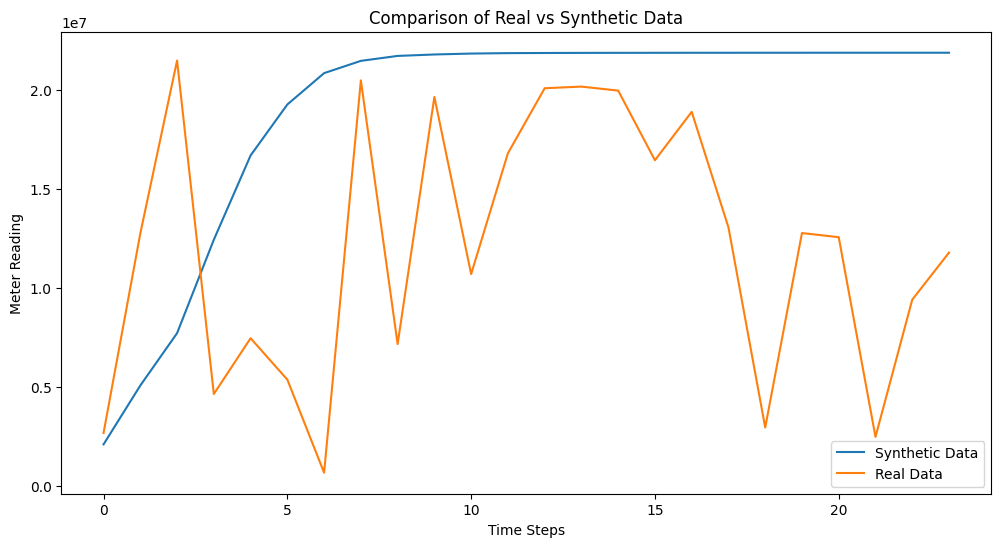

In [5]:
# Generate Synthetic Data
num_samples = 100
noise = tf.random.normal([num_samples, seq_len, latent_dim])
synthetic_data = generator(noise)
synthetic_data = scaler.inverse_transform(synthetic_data.numpy().reshape(-1, 1)).reshape(num_samples, seq_len)

# Visualize Synthetic vs Real Data
plt.figure(figsize=(12, 6))
plt.plot(synthetic_data[0], label='Synthetic Data')
plt.plot(scaler.inverse_transform(sequences[0].reshape(-1, 1)), label='Real Data')
plt.xlabel('Time Steps')
plt.ylabel('Meter Reading')
plt.title('Comparison of Real vs Synthetic Data')
plt.legend()
plt.show()

In [6]:
# Calculate Mean Absolute Error between real and synthetic samples
real_sample = scaler.inverse_transform(sequences[0].reshape(-1, 1))
synthetic_sample = synthetic_data[0]
mae = mean_absolute_error(real_sample, synthetic_sample)
print(f"Mean Absolute Error between real and synthetic data: {mae:.4f}")

Mean Absolute Error between real and synthetic data: 8717068.0000


Checking using Wasserstein distance and KS test

Epoch 0/100 | Generator Loss: 0.6934 | Discriminator Loss: 1.3755
Epoch 10/100 | Generator Loss: 0.6907 | Discriminator Loss: 1.3455
Epoch 20/100 | Generator Loss: 0.6705 | Discriminator Loss: 1.3373
Epoch 30/100 | Generator Loss: 0.6142 | Discriminator Loss: 1.3733
Epoch 40/100 | Generator Loss: 0.5411 | Discriminator Loss: 1.4783
Epoch 50/100 | Generator Loss: 0.5991 | Discriminator Loss: 1.4720
Epoch 60/100 | Generator Loss: 0.6900 | Discriminator Loss: 1.4242
Epoch 70/100 | Generator Loss: 0.7648 | Discriminator Loss: 1.3888
Epoch 80/100 | Generator Loss: 0.8340 | Discriminator Loss: 1.3588
Epoch 90/100 | Generator Loss: 0.9163 | Discriminator Loss: 1.3260
Real Data Statistics:
Mean: 0.4980, Std: 0.2866, Min: 0.0000, Max: 1.0000

Generated Data Statistics:
Mean: 0.8710, Std: 0.2482, Min: -0.0073, Max: 0.9999


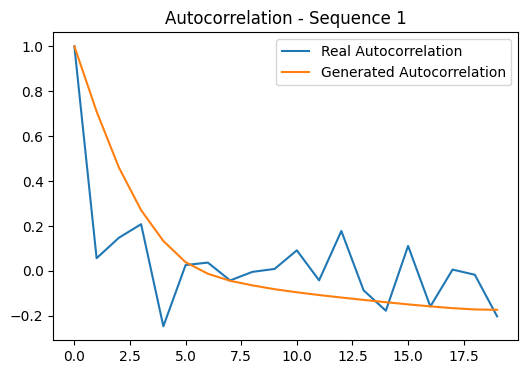

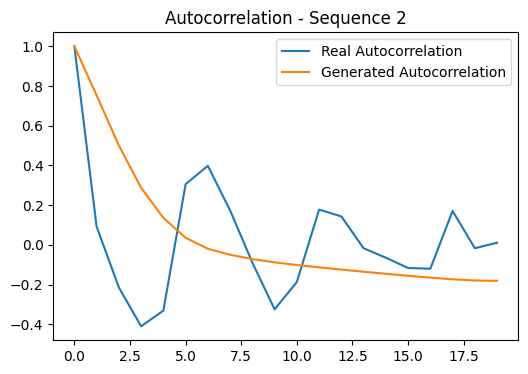

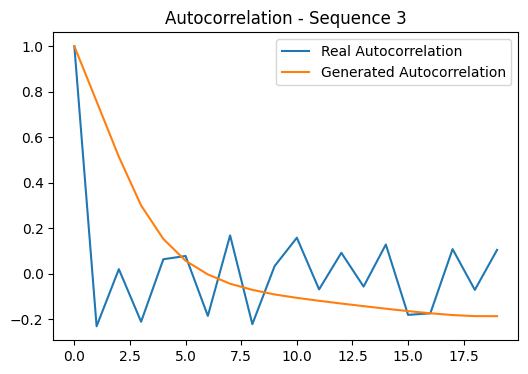

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define necessary parameters
batch_size = 64
seq_len = 24
latent_dim = 100
epochs = 100
learning_rate = 0.0002

# Enable eager execution to prevent conversion issues
tf.config.run_functions_eagerly(True)

# Define Generator Model
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, latent_dim)),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh'))
    ])
    return model

# Define Discriminator Model
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define Loss Functions
def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return tf.reduce_mean(real_loss + fake_loss)

# Build and Compile Models
generator = build_generator()
discriminator = build_discriminator()

# Build models to ensure the optimizers recognize them
_ = generator(tf.random.normal([1, seq_len, latent_dim]))
_ = discriminator(tf.random.normal([1, seq_len, 1]))

# Define Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Training Step
def train_step(real_data):
    # Sample random noise
    noise = tf.random.normal([batch_size, seq_len, latent_dim])

    # Generate synthetic sequences
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        # Discriminator predictions
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        # Calculate Losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply Gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate Dummy Sequence Data for Training
sequences = np.random.rand(1000, seq_len, 1).astype(np.float32)

# Training Loop
for epoch in range(epochs):
    # Sample a batch of real sequences
    idx = np.random.randint(0, len(sequences), batch_size)
    real_sequences = sequences[idx]

    # Convert to Tensor
    real_sequences = tf.convert_to_tensor(real_sequences)

    # Train the model
    gen_loss, disc_loss = train_step(real_sequences)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | Generator Loss: {gen_loss.numpy():.4f} | Discriminator Loss: {disc_loss.numpy():.4f}")

# -------------------------------
# ✅ Generate Sequences for Evaluation after Training
# -------------------------------
num_samples_to_generate = 1000
noise = tf.random.normal([num_samples_to_generate, seq_len, latent_dim])
generated_sequences = generator(noise, training=False).numpy()

# -------------------------------
# ✅ Compute statistics for real and generated data
# -------------------------------
def compute_statistics(sequences):
    mean = np.mean(sequences, axis=(0, 1))
    std = np.std(sequences, axis=(0, 1))
    min_val = np.min(sequences, axis=(0, 1))
    max_val = np.max(sequences, axis=(0, 1))
    return mean, std, min_val, max_val

# Real data statistics
real_mean, real_std, real_min, real_max = compute_statistics(sequences)

# Generated data statistics
generated_mean, generated_std, generated_min, generated_max = compute_statistics(generated_sequences)

# -------------------------------
# ✅ Print Statistics (Fixed)
# -------------------------------
print("Real Data Statistics:")
print(f"Mean: {float(real_mean.item()):.4f}, Std: {float(real_std.item()):.4f}, Min: {float(real_min.item()):.4f}, Max: {float(real_max.item()):.4f}")
print("\nGenerated Data Statistics:")
print(f"Mean: {float(generated_mean.item()):.4f}, Std: {float(generated_std.item()):.4f}, Min: {float(generated_min.item()):.4f}, Max: {float(generated_max.item()):.4f}")

# -------------------------------
# ✅ Define Autocorrelation Function
# -------------------------------
def autocorrelation(sequence):
    n = len(sequence)
    mean = np.mean(sequence)
    var = np.var(sequence)
    autocorr = np.correlate(sequence - mean, sequence - mean, mode="full") / (var * n)
    return autocorr[n - 1:]

# -------------------------------
# ✅ Sample real and generated sequences for autocorrelation comparison
# -------------------------------
num_samples_to_plot = 3
real_sequences_to_plot = sequences[:num_samples_to_plot]
generated_sequences_to_plot = generated_sequences[:num_samples_to_plot]

# -------------------------------
# ✅ Compute and Plot Autocorrelation for Real and Generated Samples
# -------------------------------
for i in range(num_samples_to_plot):
    real_autocorr = autocorrelation(real_sequences_to_plot[i].squeeze())
    generated_autocorr = autocorrelation(generated_sequences_to_plot[i].squeeze())

    plt.figure(figsize=(6, 4))
    plt.plot(real_autocorr[:20], label="Real Autocorrelation")
    plt.plot(generated_autocorr[:20], label="Generated Autocorrelation")
    plt.title(f"Autocorrelation - Sequence {i + 1}")
    plt.legend()
    plt.show()